In [35]:
import os
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'figure.dpi':100})

In [36]:
FILEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/data/interim'
LANDTHRESH = 0.5

In [52]:
variables = {
    'pr':{
        'data':xr.open_dataarray(f'{FILEDIR}/pr.nc',engine='h5netcdf'),
        'label':'P',
        'is_4D':False,
        'analyze':False},
    'lf':{
        'data':xr.open_dataarray(f'{FILEDIR}/lf.nc',engine='h5netcdf'),
        'label':'LF',
        'is_4D':False,
        'analyze':False},
    'lhf':{
        'data':xr.open_dataarray(f'{FILEDIR}/lhf.nc',engine='h5netcdf'),
        'label':'LHF',
        'is_4D':False,
        'analyze':True},
    'shf':{
        'data':xr.open_dataarray(f'{FILEDIR}/shf.nc',engine='h5netcdf'),
        'label':'SHF',
        'is_4D':False,
        'analyze':True},
    'bl':{
        'data':xr.open_dataarray(f'{FILEDIR}/bl.nc',engine='h5netcdf'),
        'label':'$\\mathit{B_L}$',
        'is_4D':False,
        'analyze':True},
    'cape':{
        'data':xr.open_dataarray(f'{FILEDIR}/cape.nc',engine='h5netcdf'),
        'label':'$CAPE_L$',
        'is_4D':False,
        'analyze':True},
    'subsat':{
        'data':xr.open_dataarray(f'{FILEDIR}/subsat.nc',engine='h5netcdf'),
        'label':'$SUBSAT_L$',
        'is_4D':False,
        'analyze':True},
    'rh':{
        'data':xr.open_dataarray(f'{FILEDIR}/rh.nc',engine='h5netcdf'),
        'label':'RH',
        'is_4D':True,
        'analyze':True},
    'thetae':{
        'data':xr.open_dataarray(f'{FILEDIR}/thetae.nc',engine='h5netcdf'),
        'label':'$\\mathit{\\theta_{e}}$',
        'is_4D':True,
        'analyze':True},
    'thetaestar':{
        'data':xr.open_dataarray(f'{FILEDIR}/thetaestar.nc',engine='h5netcdf'),
        'label':'$\\mathit{\\theta_{e}}^*$',
        'is_4D':True,
        'analyze':True}}

In [53]:
pr = variables['pr']['data'].load().transpose('lat','lon','time')
lf = variables['lf']['data'].load().transpose('lat','lon')

landmask  = np.broadcast_to((lf.values>=LANDTHRESH)[...,None],pr.values.shape)
oceanmask = ~landmask

In [56]:
def corr(x,y,landmask,oceanmask,nsamples=None,seed=42):
    rng = np.random.default_rng(seed)
    xflat,yflat = x.ravel(),y.ravel()
    lflat,oflat = landmask.ravel(),oceanmask.ravel()
    finite = np.isfinite(xflat)&np.isfinite(yflat)
    xflat,yflat = xflat[finite],yflat[finite]
    lflat,oflat = lflat[finite],oflat[finite]
    if nsamples and xflat.size>nsamples:
        idx = rng.choice(xflat.size,nsamples,replace=False)
        xflat,yflat = xflat[idx],yflat[idx]
        lflat,oflat = lflat[idx],oflat[idx]
    def r(a,b):
        if a.size<2:
            return np.nan
        a = a-a.mean()
        b = b-b.mean()
        denom = np.sqrt((a*a).sum()*(b*b).sum())
        return np.nan if denom==0 else (a*b).sum()/denom
    return dict(all=r(xflat,yflat),land=r(xflat[lflat],yflat[lflat]),ocean=r(xflat[oflat],yflat[oflat]))

In [57]:
results = {}
for varname,info in variables.items():
    if not info.get('analyze',False):
        continue
    nsamples = 6250 if info['is_4D'] else 100000
    xdata    = info['data'].load()
    if info['is_4D']:
        xvalues = xdata.transpose('lat','lon','lev','time').values
        nlevs   = xvalues.shape[2]
        corrout = {kind:np.full(nlevs,np.nan) for kind in ('all','land','ocean')}
        for levidx in range(nlevs):
            xlev  = xvalues[:,:,levidx,:]  
            corrs = corr(xlev,pr.values,landmask,oceanmask,nsamples,42+levidx)
            for kind in corrout:
                corrout[kind][levidx] = corrs[kind]
        results[varname] = corrout
    else:
        xvalues = xdata.transpose('lat','lon','time').values
        results[varname] = corr(xvalues,pr.values,landmask,oceanmask,nsamples,42)

In [58]:
varnames  = list(results.keys())
varlabels = [variables[v]['label'] for v in varnames]

summaryrows = []
for varname in varnames:
    corr = results[varname]
    if variables[varname]['is_4D']:
        allcorr   = np.nanmean(corr['all'])
        landcorr  = np.nanmean(corr['land'])
        oceancorr = np.nanmean(corr['ocean'])
    else:
        allcorr   = corr['all']
        landcorr  = corr['land']
        oceancorr = corr['ocean']
    summaryrows.append([allcorr,landcorr,oceancorr])

summaryarr = np.array(summaryrows)

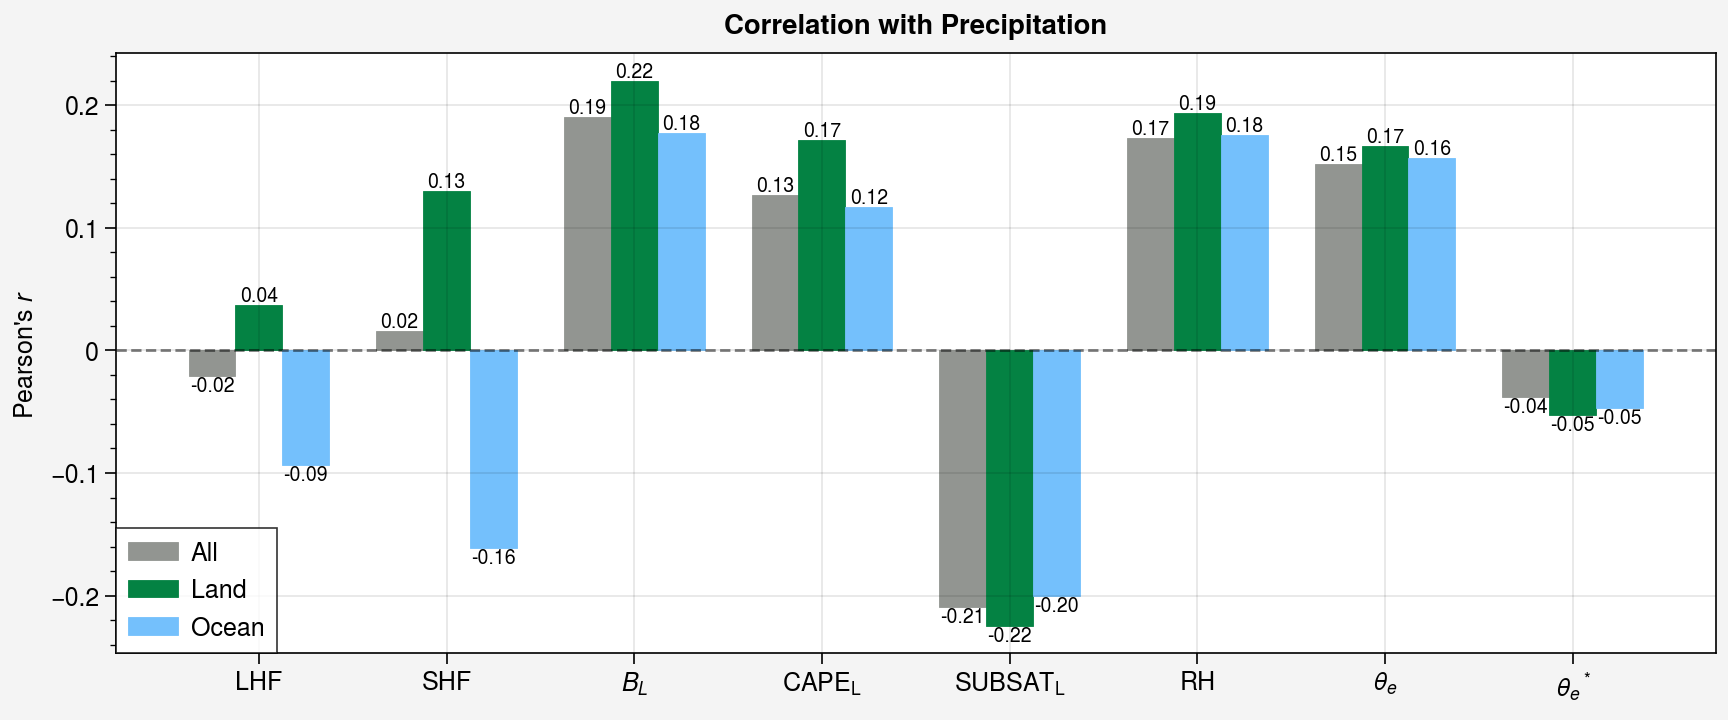

In [61]:
fig,ax     = pplt.subplots(nrows=1,ncols=1,refwidth=8,refheight=3)
xidx,width = np.arange(len(varlabels)),0.25
ax.format(suptitle='Correlation with Precipitation',xlocator=xidx,xformatter=varlabels,xminorticks='none',
          ylabel="Pearson's $\mathit{r}$")
ax.bar(xidx-width,summaryarr[:,0],width,label='All', color='gray')
ax.bar(xidx,summaryarr[:,1],width,label='Land',color='jungle green')
ax.bar(xidx+width,summaryarr[:,2],width,label='Ocean',color='blue3')
for i,(allvalue,landvalue,oceanvalue) in enumerate(summaryarr):
    ax.text(i-width,allvalue,f'{allvalue:.2f}',ha='center',va='bottom' if allvalue>0 else 'top',fontsize=7)
    ax.text(i,landvalue, f'{landvalue:.2f}',ha='center',va='bottom' if landvalue>0 else 'top',fontsize=7)
    ax.text(i+width,oceanvalue,f'{oceanvalue:.2f}',ha='center',va='bottom' if oceanvalue>0 else 'top',fontsize=7)
ax.axhline(0,color='k',alpha=0.5,linewidth=1,linestyle='--')
ax.legend(loc='ll',ncols=1)
pplt.show()

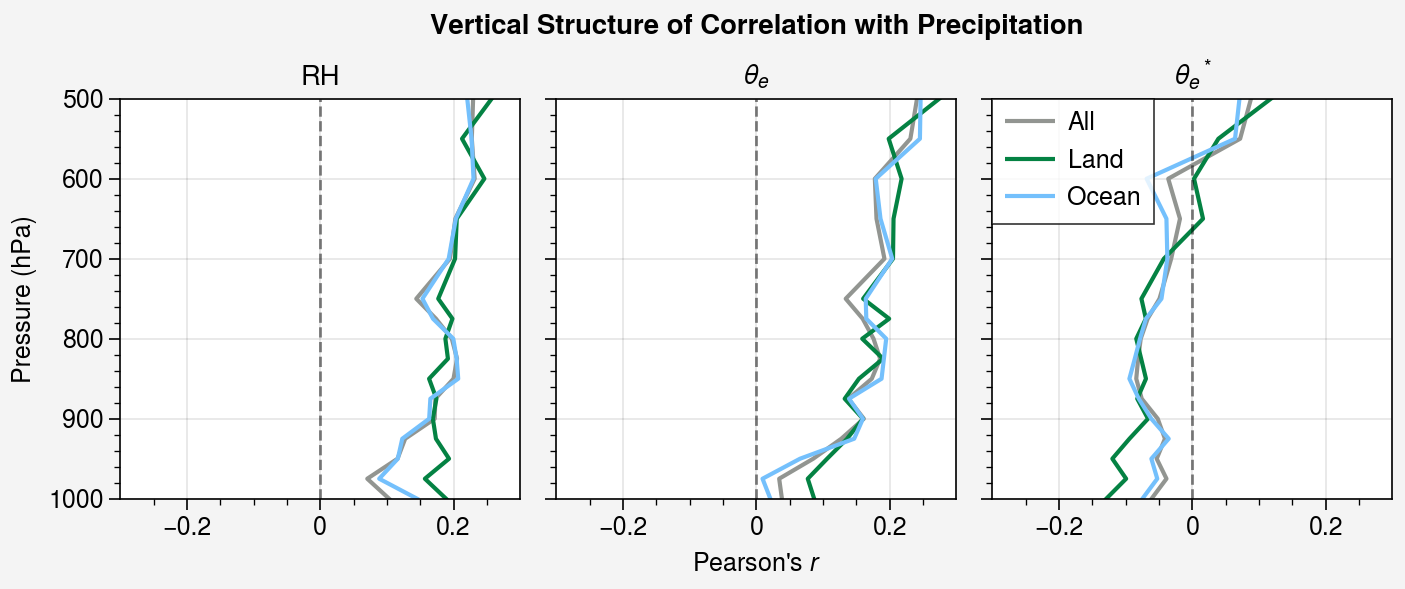

In [63]:
vars4d = [v for v in varnames if variables[v]['is_4D']]
if vars4d:
    fig,axs = pplt.subplots(ncols=len(vars4d),refwidth=2,share=True)
    axs.format(suptitle='Vertical Structure of Correlation with Precipitation',xlabel="Pearson's $\mathit{r}$",
               ylabel='Pressure (hPa)',yreverse=True,ylim=(1000,500))
    for i,varname in enumerate(vars4d):
        corr = results[varname]
        levs = variables[varname]['data']['lev'].values
        axs[i].plot(corr['all'],levs,label='All',color='gray',linewidth=1.5)
        axs[i].plot(corr['land'],levs,label='Land',color='jungle green',linewidth=1.5)
        axs[i].plot(corr['ocean'],levs,label='Ocean',color='blue3',linewidth=1.5)
        axs[i].format(title=variables[varname]['label'],xlim=(-0.3,0.3))
        axs[i].axvline(0,color='k',linewidth=1,linestyle='--',alpha=0.5)
    axs[-1].legend(loc='ul',ncols=1)
    pplt.show()